In [1]:
import os
import pandas as pd
import cv2

DIR = "data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
df

,super_category,category,path
0,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
1,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
2,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
3,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
4,Cortinarius,Cortinarius uliginosus f. uliginosus,data/fungi_train_val/12665_Cortinarius_uligino...
...,...,...,...
89755,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89756,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89757,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...
89758,Cheilymenia,Cheilymenia granulata,data/fungi_train_val/12195_Cheilymenia_granula...


In [3]:
df_sorted = df.groupby(['super_category']).count().rename(columns={'path':'count'})[['count']].sort_values(by='count', ascending=False)
df_sorted

,count
super_category,
Russula,4346
Cortinarius,4313
Mycena,3958
Lactarius,2310
Hygrocybe,2161
...,...
Phragmidium,7
Trichopeziza,7
Chamaemyces,6


In [4]:
reference = 'super_category'
n_classes = 3
samples_per_class = 100
training_size_ratio = 0.9

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:n_classes].iterrows():
    size = min(samples_per_class, df.loc[df[reference] == i].shape[0])
    training_size = int(size*training_size_ratio)
    tmp_df = df.loc[df[reference] == i].iloc[:training_size]
    tmp_df['training'] = 1
    df1 = df1.append(tmp_df)
    tmp_df = df.loc[df[reference] == i].iloc[training_size:samples_per_class]
    tmp_df['training'] = 0
    df1 = df1.append(tmp_df)
    
df1.head()

,super_category,category,path,training
50,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/PTP2...,1
51,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1
52,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/PEL2...,1
53,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1
54,Russula,Russula fellea,data/fungi_train_val/19970_Russula_fellea/TS20...,1


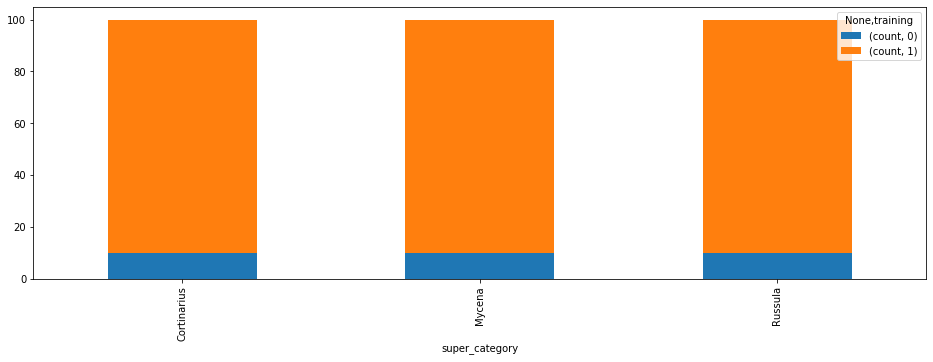

In [5]:
import pandas as pd

df_count = df1.groupby(['super_category','training']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('training')
df_count.plot(kind='bar', stacked=True, figsize=(16,5))

In [6]:
df_training = df1.loc[df1['training'] == 1]
df_validation = df1.loc[df1['training'] == 0]

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])

Training set: 270
Validation set: 30


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
training_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

img_size = 224

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'super_category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 270 validated image filenames belonging to 3 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'super_category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 30 validated image filenames belonging to 3 classes.


In [9]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

print(classes, len(classes))

['Cortinarius', 'Mycena', 'Russula'] 3


In [16]:
# From https://stackoverflow.com/a/45389215

from tensorflow.keras import applications
#from tensorflow.keras.layers import Input

# If you want to specify input tensor
#input_tensor = Input(shape=(150, 150, 3))
vgg_model = applications.VGG16(weights='models/vgg16_weights.h5', include_top=True)

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(classes), activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
model = Model(vgg_model.input, x)

for layer in model.layers[:19]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer.name, layer.trainable)

# Do not forget to compile it
model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
conv2d_19 True
max_pooling2d_19 True
flatten_19 True
dense_38 True
dropout_19 True
dense_39 True


In [39]:
model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_generator, epochs=100,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping,checkpoint_callback])

model.load_weights(checkpoint_filepath)
model.save('model.h5')

Epoch 1/100
9/9 [==============================] - 86s 10s/step - loss: 1.5840 - accuracy: 0.3407 - val_loss: 1.1100 - val_accuracy: 0.3333
Epoch 2/100
9/9 [==============================] - 78s 9s/step - loss: 1.0442 - accuracy: 0.4519 - val_loss: 1.4534 - val_accuracy: 0.3667
Epoch 3/100
9/9 [==============================] - 77s 9s/step - loss: 1.1593 - accuracy: 0.4407 - val_loss: 0.8433 - val_accuracy: 0.7333
Epoch 4/100
9/9 [==============================] - 77s 9s/step - loss: 0.9626 - accuracy: 0.5556 - val_loss: 0.7982 - val_accuracy: 0.6333
Epoch 5/100
9/9 [==============================] - 77s 9s/step - loss: 0.8926 - accuracy: 0.5815 - val_loss: 0.7253 - val_accuracy: 0.6667
Epoch 6/100
9/9 [==============================] - 77s 9s/step - loss: 0.9472 - accuracy: 0.5815 - val_loss: 0.7531 - val_accuracy: 0.6667
Epoch 7/100
9/9 [==============================] - 77s 9s/step - loss: 0.8393 - accuracy: 0.5704 - val_loss: 0.9036 - val_accuracy: 0.5667
Epoch 8/100
9/9 [=========

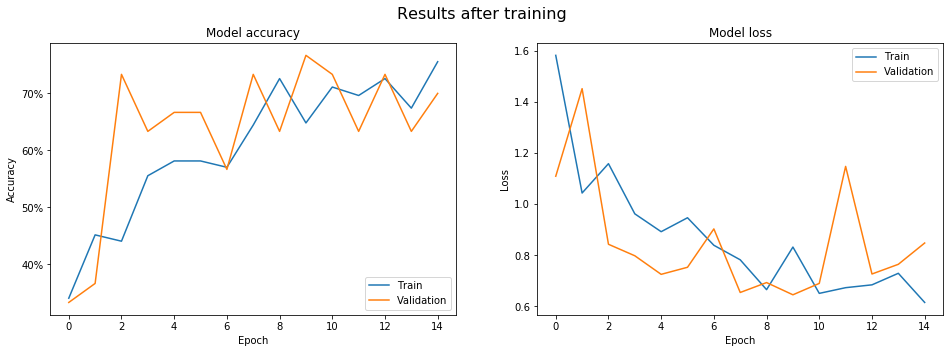

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [42]:
val_loss, val_acc = model.evaluate(validation_generator)

1/1 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.7667


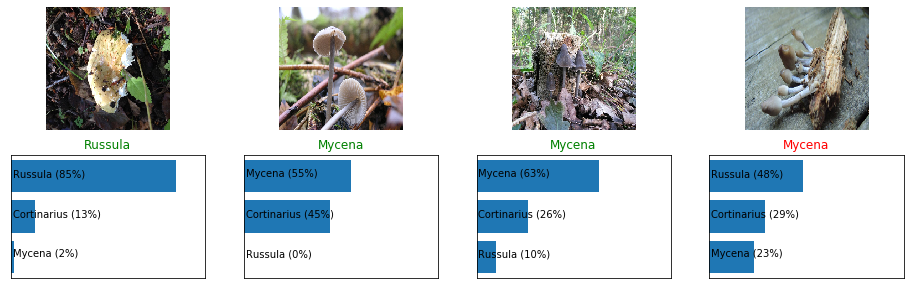

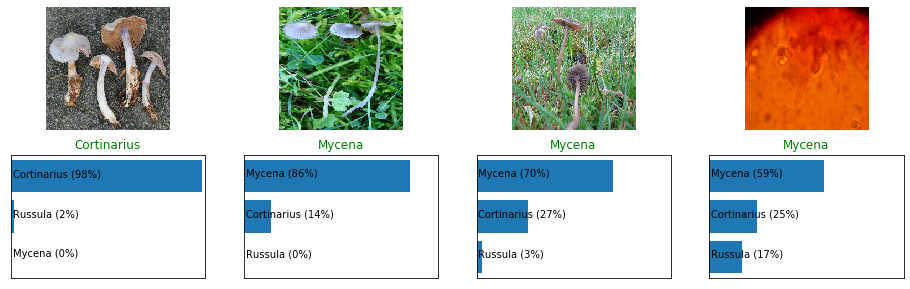

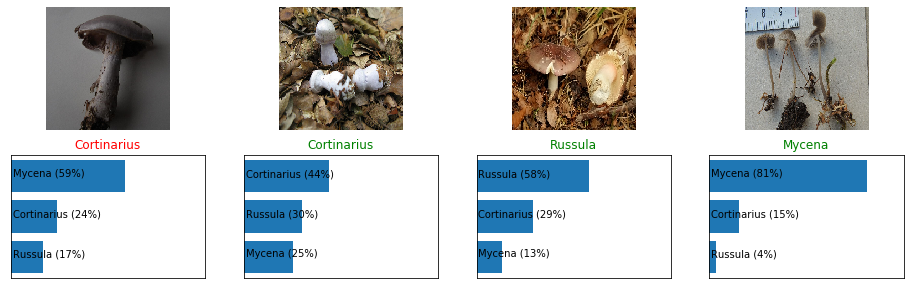

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import numpy as np

iters = 0
n_predictions = 8
n_cols = 4
    
for i, batch in enumerate(validation_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()